In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, root_mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("ploeg_final_df.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for ervaring in df['ervaring'].unique():
    for geslacht in df['binary_geslacht'].unique():
        for gewichtsklasse in df['binary_gewichtsklasse'].unique():
            subset = df[(df['ervaring'] == ervaring) & (df['binary_geslacht'] == geslacht) & (df['binary_gewichtsklasse'] == gewichtsklasse)]
            if not subset.empty:
                temp_train, temp_temp = train_test_split(subset, test_size=0.3, random_state=42)
                temp_val, temp_test = train_test_split(temp_temp, test_size=0.3, random_state=42)
                train_data = pd.concat([train_data, temp_train])
                val_data = pd.concat([val_data, temp_val])
                test_data = pd.concat([test_data, temp_test])

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print(f"Trainingsdata: {len(train_data)} rijen")
print(f"Validatiedata: {len(val_data)} rijen")
print(f"Testdata: {len(test_data)} rijen")

X_train = train_data.drop(columns=['2k tijd'])
y_train = train_data['2k tijd']
X_val = val_data.drop(columns=['2k tijd'])
y_val = val_data['2k tijd']
X_test = test_data.drop(columns=['2k tijd'])
y_test = test_data['2k tijd']

Trainingsdata: 3018 rijen
Validatiedata: 905 rijen
Testdata: 391 rijen


In [4]:
def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse_scorer, greater_is_better=False)

def feature_engineering(df):
    df['interaction_split_training'] = df['500_split'] * df['binary_trainingtype']
    df['interaction_split_geslacht'] = df['500_split'] * df['binary_geslacht']
    df['interaction_split_ervaring'] = df['500_split'] * df['ervaring']
    # df['interaction_split_gewicht'] = df['500_split'] * df['binary_gewichtsklasse'] 
    return df

X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

Cross-Validated RMSE: -7.821
mse_train = 37.13587532514119
mse_val = 62.18026460243332
mse_test = 45.6061504325912
rmse_test = 6.753232591329222
train_r2 = 0.9642623695713385
val_r2 = 0.9392148333006655
test_r2 = 0.9555892328707662
mae_train = 4.643099585268337
mae_val = 5.996677165163156
mae_test = 5.178383954528653
   Actual 2k tijd  Predicted 2k tijd (XGBoost)  Difference (XGBoost)
0           427.7                   420.294250              7.405750
1           420.5                   426.457001             -5.957001
2           418.6                   419.110291             -0.510291
3           427.7                   425.845520              1.854480
4           427.7                   426.871155              0.828845
5           420.5                   424.073761             -3.573761
6           421.9                   419.897888              2.002112
7           449.0                   433.283081             15.716919
8           431.6                   432.562775             -

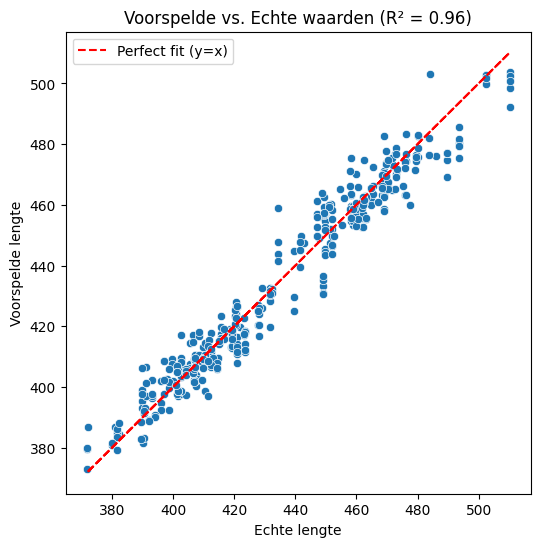

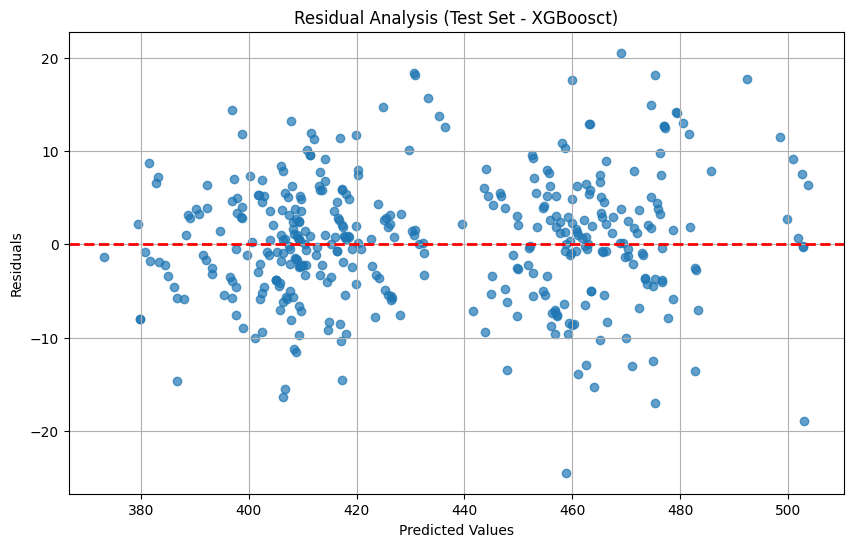

<Figure size 1000x600 with 0 Axes>

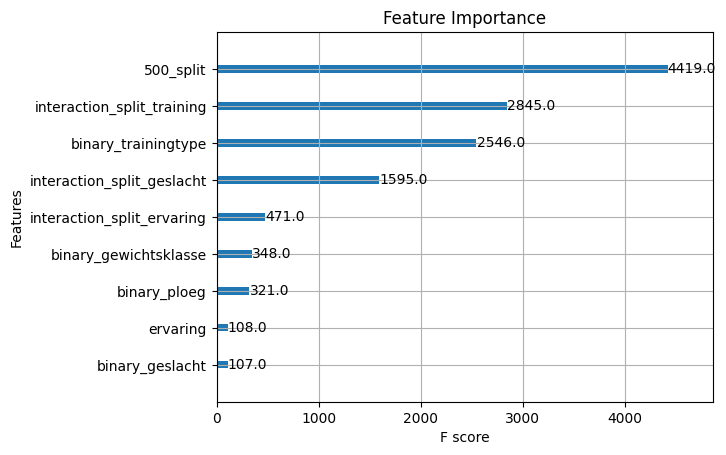

Test RMSE: 6.753232591329222


<Figure size 2000x1000 with 0 Axes>

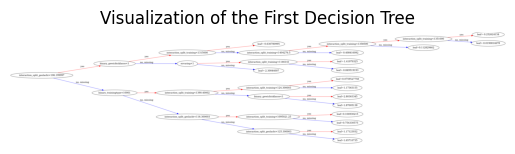

<Figure size 2000x1000 with 0 Axes>

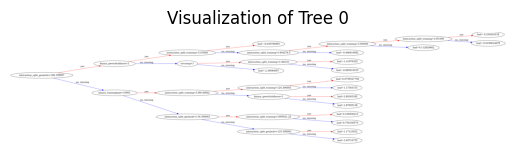

<Figure size 2000x1000 with 0 Axes>

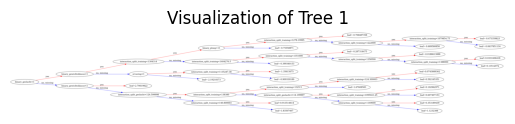

<Figure size 2000x1000 with 0 Axes>

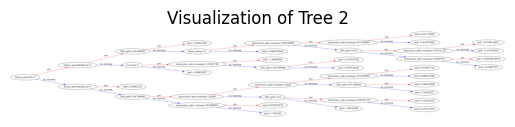

In [5]:
xgb_model = XGBRegressor(objective="reg:squarederror", 
                             random_state=42, 
                             reg_lambda=10,
                             min_child_weight=3, 
                             colsample_bytree=0.8, 
                             learning_rate=0.05, 
                             max_depth=7, 
                             n_estimators=300)

xgb_model.fit(X_train, y_train)

train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)
val_pred = xgb_model.predict(X_val)

cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring=scorer, cv=kf)
print(f"Cross-Validated RMSE: {-np.mean(cv_scores):.3f}")

mse_train = mean_squared_error(y_train, train_pred)
mse_val = mean_squared_error(y_val, val_pred)
mse_test = mean_squared_error(y_test, test_pred)
print(f"mse_train = {mse_train}")
print(f"mse_val = {mse_val}")
print(f"mse_test = {mse_test}")

rmse_test = np.sqrt(mse_test)
print(f"rmse_test = {rmse_test}")

train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"train_r2 = {train_r2}")
print(f"val_r2 = {val_r2}")
print(f"test_r2 = {test_r2}")

mae_train = mean_absolute_error(y_train, train_pred)
mae_val = mean_absolute_error(y_val, val_pred)
mae_test = mean_absolute_error(y_test, test_pred)
print(f"mae_train = {mae_train}")
print(f"mae_val = {mae_val}")
print(f"mae_test = {mae_test}")

results_xgb = pd.DataFrame({
    'Actual 2k tijd': y_test,
    'Predicted 2k tijd (XGBoost)': test_pred,
    'Difference (XGBoost)': y_test - test_pred
})
print(results_xgb.head(10))

#r2 score
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=test_pred)
plt.plot(y_test, y_test, color="red", linestyle="--", label="Perfect fit (y=x)")
plt.xlabel("Echte lengte")
plt.ylabel("Voorspelde lengte")
plt.title(f"Voorspelde vs. Echte waarden (R² = {test_r2:.2f})")
plt.show()

#hovering plot voorspellingen test set
import plotly.express as px
import plotly.graph_objects as go

data = pd.DataFrame({'Actual': y_test, 'Predicted': test_pred})
fig = px.scatter(data, x='Actual', y='Predicted', title="Actual vs Predicted Values")
min_val = min(data['Actual'].min(), data['Predicted'].min())
max_val = max(data['Actual'].max(), data['Predicted'].max())
fig.add_trace(go.Scatter(x=[min_val, max_val], y=[min_val, max_val], mode='lines', 
                         name='Perfect Prediction', line=dict(color='red')))
fig.show()

#residuals plot
residuals_xgb = y_test - test_pred
plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals_xgb, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.grid(True)
plt.show()

#feature analysis
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("Feature Importance")
plt.show()

test_pred = xgb_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test RMSE:", test_rmse)

from xgboost import plot_tree

#eerste decision tree
plt.figure(figsize=(20, 10))
plot_tree(xgb_model, num_trees=0, rankdir='LR') 
plt.title("Visualization of the First Decision Tree")
plt.show()

#meer decision trees
num_trees_to_plot = 3
for i in range(num_trees_to_plot):
    plt.figure(figsize=(20, 10))
    plot_tree(xgb_model, num_trees=i, rankdir='LR')
    plt.title(f"Visualization of Tree {i}")
    plt.show()


In [14]:
param_grid = {'reg_lambda': [1, 10, 100, 150], 
              'min_child_weight': [1, 3, 5, 7], 
              'colsample_bytree': [0.6, 0.8, 1.0],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
              'max_depth': [5, 7, 9],
              'n_estimators': [100, 200, 300, 400, 500]}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_lambda = grid_search.best_params_['reg_lambda']
best_min_child_weight = grid_search.best_params_['min_child_weight']
best_colsample = grid_search.best_params_['colsample_bytree']
best_learningrate = grid_search.best_params_['learning_rate']
best_maxdepth = grid_search.best_params_['max_depth']
best_nestimators = grid_search.best_params_['n_estimators']
print('Best lambda (reg_lambda):', best_lambda)
print('Best child weight:', best_min_child_weight)
print('Best colsample:', best_colsample)
print('Best learning rate:', best_learningrate)
print('Best maxdepth:', best_maxdepth)
print('Best estimators:', best_nestimators)


KeyboardInterrupt: 

In [11]:
df = pd.read_csv("final_df.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()
for ervaring in df['ervaring'].unique():
    for geslacht in df['binary_geslacht'].unique():
        for gewichtsklasse in df['binary_gewichtsklasse'].unique():
            subset = df[(df['ervaring'] == ervaring) & 
                        (df['binary_geslacht'] == geslacht) & 
                        (df['binary_gewichtsklasse'] == gewichtsklasse)]
            if not subset.empty:
                temp_train, temp_temp = train_test_split(subset, test_size=0.3, random_state=42)
                temp_val, temp_test = train_test_split(temp_temp, test_size=0.3, random_state=42)
                train_data = pd.concat([train_data, temp_train])
                val_data = pd.concat([val_data, temp_val])
                test_data = pd.concat([test_data, temp_test])

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

X_train = train_data.drop(columns=['2k tijd'])
y_train = train_data['2k tijd']

X_val = val_data.drop(columns=['2k tijd'])
y_val = val_data['2k tijd']

X_test = test_data.drop(columns=['2k tijd'])
y_test = test_data['2k tijd']

baseline_model = XGBRegressor(random_state=42, n_estimators=100)
baseline_model.fit(X_train, y_train)

val_preds = baseline_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = root_mean_squared_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)

print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R2: {val_r2}")

#hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 300, 400],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


best_model = XGBRegressor(**best_params, random_state=42)
best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

test_preds = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")

#feature analysis
importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

#cross validation
cv_scores = cross_val_score(
    best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'
)
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-Validation RMSE: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean()}")

#residuals
residuals = y_test - test_preds
print("Residual Analysis:")
print(f"Mean Residual: {np.mean(residuals)}")
print(f"Residual Std Dev: {np.std(residuals)}")



Validation MSE: 66.50744379765271
Validation RMSE: 8.155209610896136
Validation R2: 0.9349847401931329
Fitting 3 folds for each of 972 candidates, totalling 2916 fits


KeyboardInterrupt: 